<br><font color='darkblue' size=8>Detecting Skin Cancer Using<br>Deep Convolutional Neural Network</font>
# <font color='darkblue'>Problem Statement:</font> 

In this notebook, we're going to build a <font color='darkblue'><b>multiclass classification model</b></font> using a custom <font color='darkblue'><b>convolutional neural network</b></font> in <font color='darkblue'><b>TensorFlow</b></font> & <font color='darkblue'><b>Keras</b></font>. 

The objective is to build a model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. Our deep convolutional neural network will analyze dermoscopic images and warn the dermatologists about the signs of melanoma. It can play a vital role in earlier and faster diagnosis and can reduce a lot of manual effort needed in the process.<br><br>

The <font color='darkblue'><b>dataset</b></font> consists of <font color='darkblue'><b>2357 images</b></font> of <font color='darkblue'><b>malignant</b></font> and <font color='darkblue'><b>benign oncological diseases</b></font>, which were formed from the <font color='darkblue'><b>International Skin Imaging Collaboration (ISIC)</b></font>. All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

# <font color='darkblue'>Loading the dependencies</font>

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [2]:
# inputting the path for train and test images
train_path="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
test_path="Skin cancer ISIC The International Skin Imaging Collaboration/Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [3]:
# counting the number of train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'There are {image_count_train} training images')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'There are {image_count_test} testing images')

There are 2239 training images
There are 118 testing images


# <font color='darkblue'>Data Preparation</font>

In [4]:
# setting the batch size, height & width of the images
# we're going to use the same setting for all the different models
batch_size = 32
img_height = 180
img_width = 180

We're going to use <font color='darkblue'><b>80%</b></font> of the <font color='darkblue'><b>images</b></font> in the training set for <font color='darkblue'><b>training</b></font> purposes, and <font color='darkblue'><b>20%</b></font> for <font color='darkblue'><b>validation</b></font>. We're <font color='darkblue'><b>inferring</b></font> the <font color='darkblue'><b>labels</b></font> of the images from the <font color='darkblue'><b>folder name</b></font> itself and we're passing in relevant <font color='darkblue'><b>arguments</b></font> for <font color='darkblue'><b>batch_size</b></font>, <font color='darkblue'><b>image_size</b></font> as defined above

In [5]:
# creating the training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, 
    image_size=(img_height, img_width), shuffle=True, seed=123, 
    validation_split=0.2, subset='training', interpolation='bilinear', 
    follow_links=False, smart_resize=False)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
# creating the testing set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, 
    image_size=(img_height, img_width), shuffle=True, seed=123, 
    validation_split=0.2, subset='validation', interpolation='bilinear', 
    follow_links=False, smart_resize=False)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# viewing the class names inferred from the folder names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# <font color='darkblue'>Visualizing the Data</font>

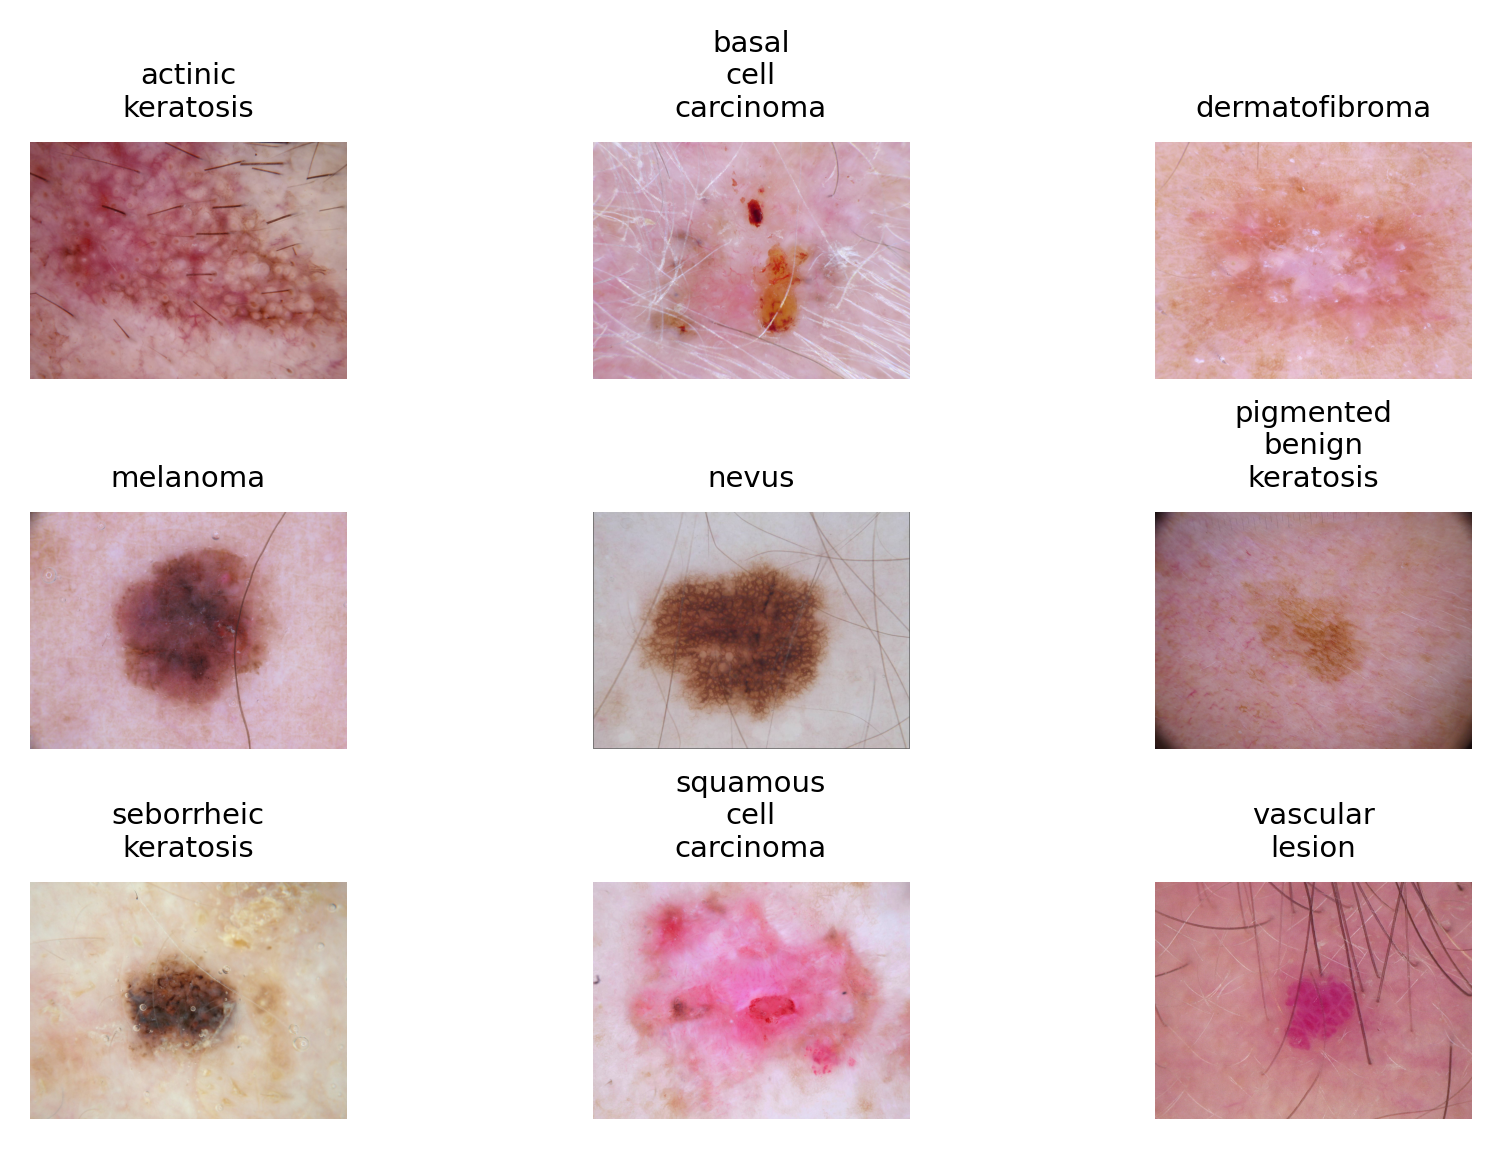

In [8]:
# we're viewing the one image for each class of skin cancer
import matplotlib.pyplot as plt
num=0
plt.figure(dpi=300)
for dirpath, dirnames, filenames in os.walk(str(train_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        disease = str(dirpath).split('/')[-1]
        disease = '\n'.join(disease.split())
        plt.title(disease, fontdict={'fontsize':7})
        plt.tight_layout(pad=0.5, w_pad=0.)
        plt.imshow(img)
        plt.axis('off')
        num = num + 1

The <font color='darkblue'><b>image_batch</b></font> is a tensor of the shape <font color='darkblue'><b>(32, 180, 180, 3)</b></font>. This is a batch of <font color='darkblue'><b>32 images</b></font> of shape <font color='darkblue'><b>180x180x3</b></font> (the last dimension refers to color channels RGB). The <font color='darkblue'><b>label_batch</b></font> is a tensor of the shape <font color='darkblue'><b>(32,)</b></font>, these are corresponding labels to the 32 images.

<font color='darkblue'><b>Dataset.cache()</b></font> keeps the images in memory after they're loaded off disk during the first epoch.

<font color='darkblue'><b>Dataset.prefetch()</b></font> overlaps data preprocessing and model execution while training.

<font color='darkblue'><b>AUTOTUNE</b></font> is a parameter of <font color='darkblue'><b>prefetch()</b></font> which lets the system decide the optimal number of batches to be preloaded.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# <font color='darkblue'>Building 1st model: dcnn1</font>

In [10]:
# building the deep CNN architecture with 2 convolutional units (convolutional layer + maxpool)
# and 1 fully connected layer and dropout layers in between
# using softmax layer for the output 
dcnn1=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

In [11]:
# compiling the above DCNN model with adam optimizer and categorical_crossentropy loss
dcnn1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# training the model for 20 epochs using the train_ds
epochs = 20
history = dcnn1.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs)

Epoch 1/20
56/56 [==============================] - 9s 59ms/step - loss: 3.3050 - accuracy: 0.1998 - val_loss: 2.0748 - val_accuracy: 0.2148
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 2.0090 - accuracy: 0.2366 - val_loss: 1.9587 - val_accuracy: 0.3289
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.8614 - accuracy: 0.3125 - val_loss: 1.7630 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.7624 - accuracy: 0.3795 - val_loss: 1.7355 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6656 - accuracy: 0.4051 - val_loss: 1.6647 - val_accuracy: 0.4139
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6349 - accuracy: 0.4085 - val_loss: 1.6104 - val_accuracy: 0.4362
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5922 - accuracy: 0.4386 - val_loss: 1.5553 - val_accuracy: 0.4609
Epoch 8/20
56

In [13]:
# glimpse of the architecture of dcnn1 model
dcnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

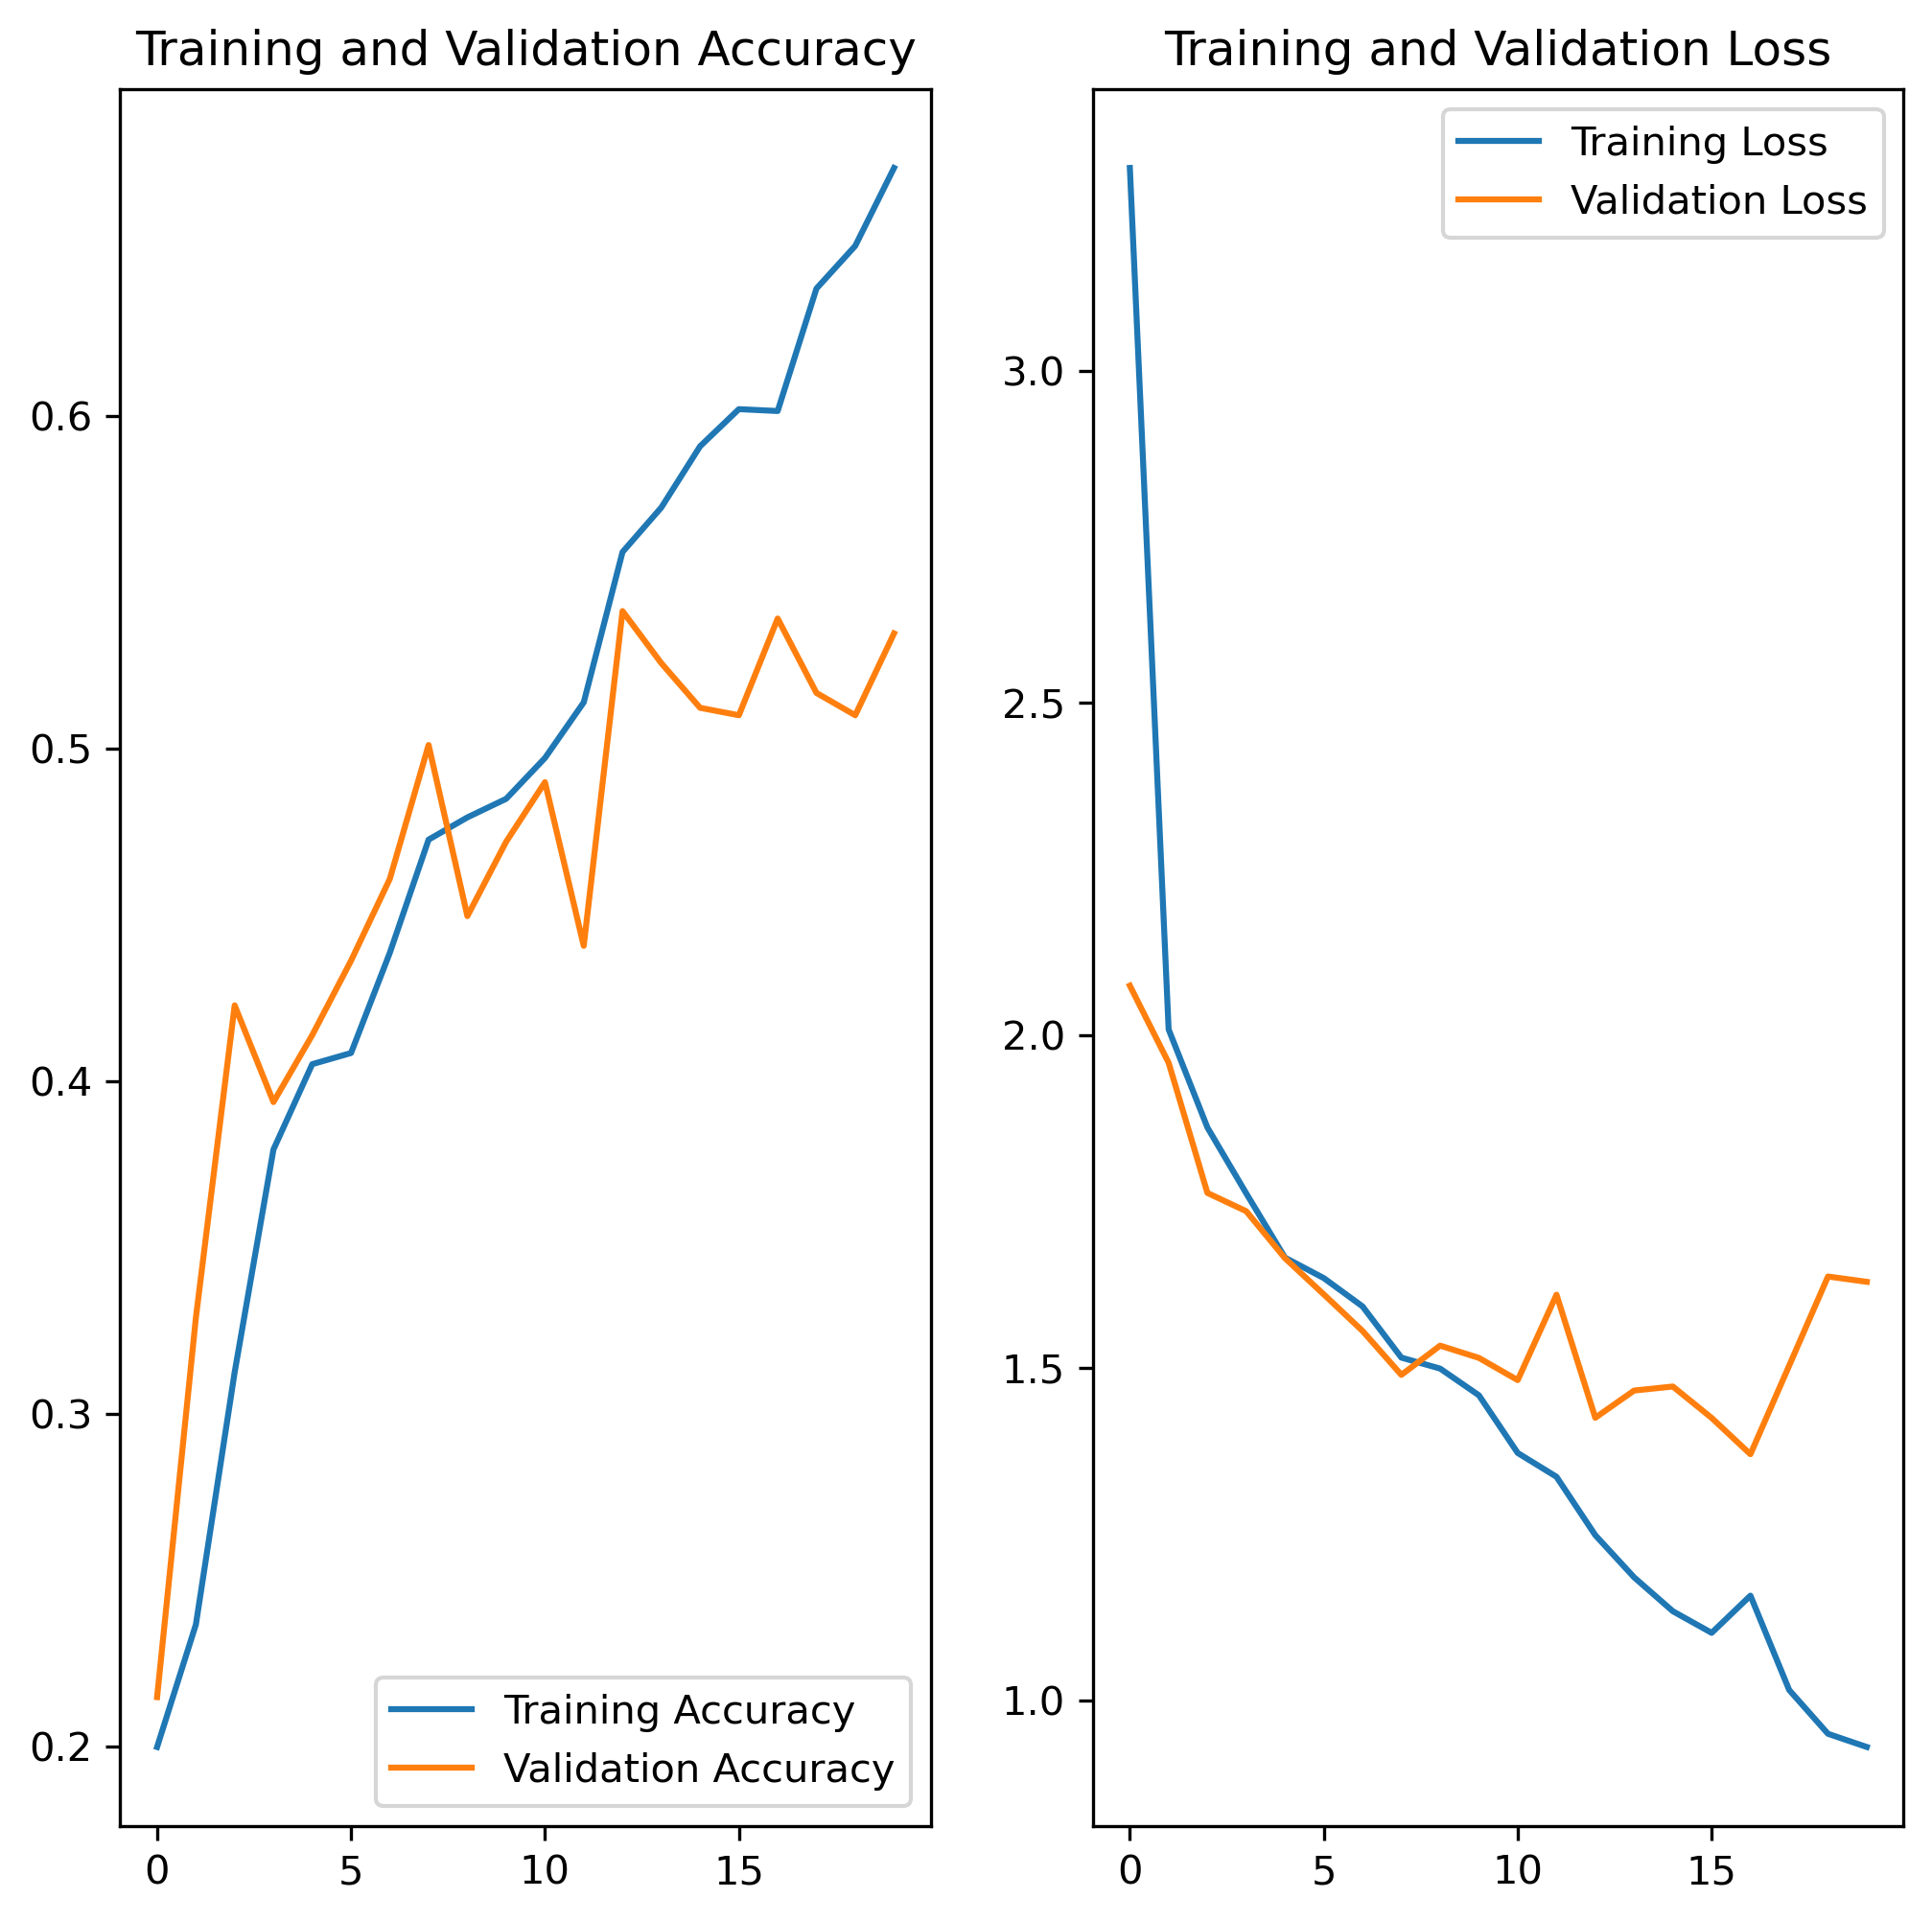

In [14]:
# visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8), dpi=300)

# plotting training and validation accuracies vs epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plotting training and validation losses vs epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# <font color='darkblue'>Performance of dcnn1:</font>
The <font color='darkblue'><b>accuracy</b></font> of the model on the <font color='darkblue'><b>training set</b></font> is at <font color='darkblue'><b>67%</b></font> which is low and on the <font color='darkblue'><b>validation set</b></font> is just <font color='darkblue'><b>53%</b></font>. This is a clear <font color='darkblue'><b>indication</b></font> of <font color='darkblue'><b>underfitting</b></font> of the model. We may have to add few additional layers and dropout layers to our <font color='darkblue'><b>DCNN model</b></font> to make it learn better and generalize better.

# <font color='darkblue'>Building 2nd model: dcnn2</font>

In [15]:
# building the deep CNN architecture with 3 convolutional units (2 convolutional layer + 1 maxpool)
# and 1 fully connected layer and dropout layers in between
# using softmax layer for the output 
dcnn2=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

In [16]:
# compiling the above DCNN model with adam optimizer and categorical_crossentropy loss
dcnn2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [17]:
# training the model for 20 epochs using the train_ds
epochs = 20
history = dcnn2.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs)

Epoch 1/20
56/56 [==============================] - 8s 107ms/step - loss: 2.0962 - accuracy: 0.1948 - val_loss: 1.9599 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 5s 96ms/step - loss: 1.9628 - accuracy: 0.2556 - val_loss: 1.8303 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 5s 96ms/step - loss: 1.7936 - accuracy: 0.3421 - val_loss: 1.7180 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 5s 96ms/step - loss: 1.7700 - accuracy: 0.3616 - val_loss: 1.7219 - val_accuracy: 0.3490
Epoch 5/20
56/56 [==============================] - 5s 96ms/step - loss: 1.6514 - accuracy: 0.3990 - val_loss: 1.6595 - val_accuracy: 0.4295
Epoch 6/20
56/56 [==============================] - 5s 96ms/step - loss: 1.6134 - accuracy: 0.4113 - val_loss: 1.6349 - val_accuracy: 0.4094
Epoch 7/20
56/56 [==============================] - 5s 96ms/step - loss: 1.5730 - accuracy: 0.4275 - val_loss: 1.5162 - val_accuracy: 0.4362
Epoch 8/20
5

In [18]:
# glimpse of the architecture of dcnn2 model
dcnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 89, 89, 64)        18496     
                                                      

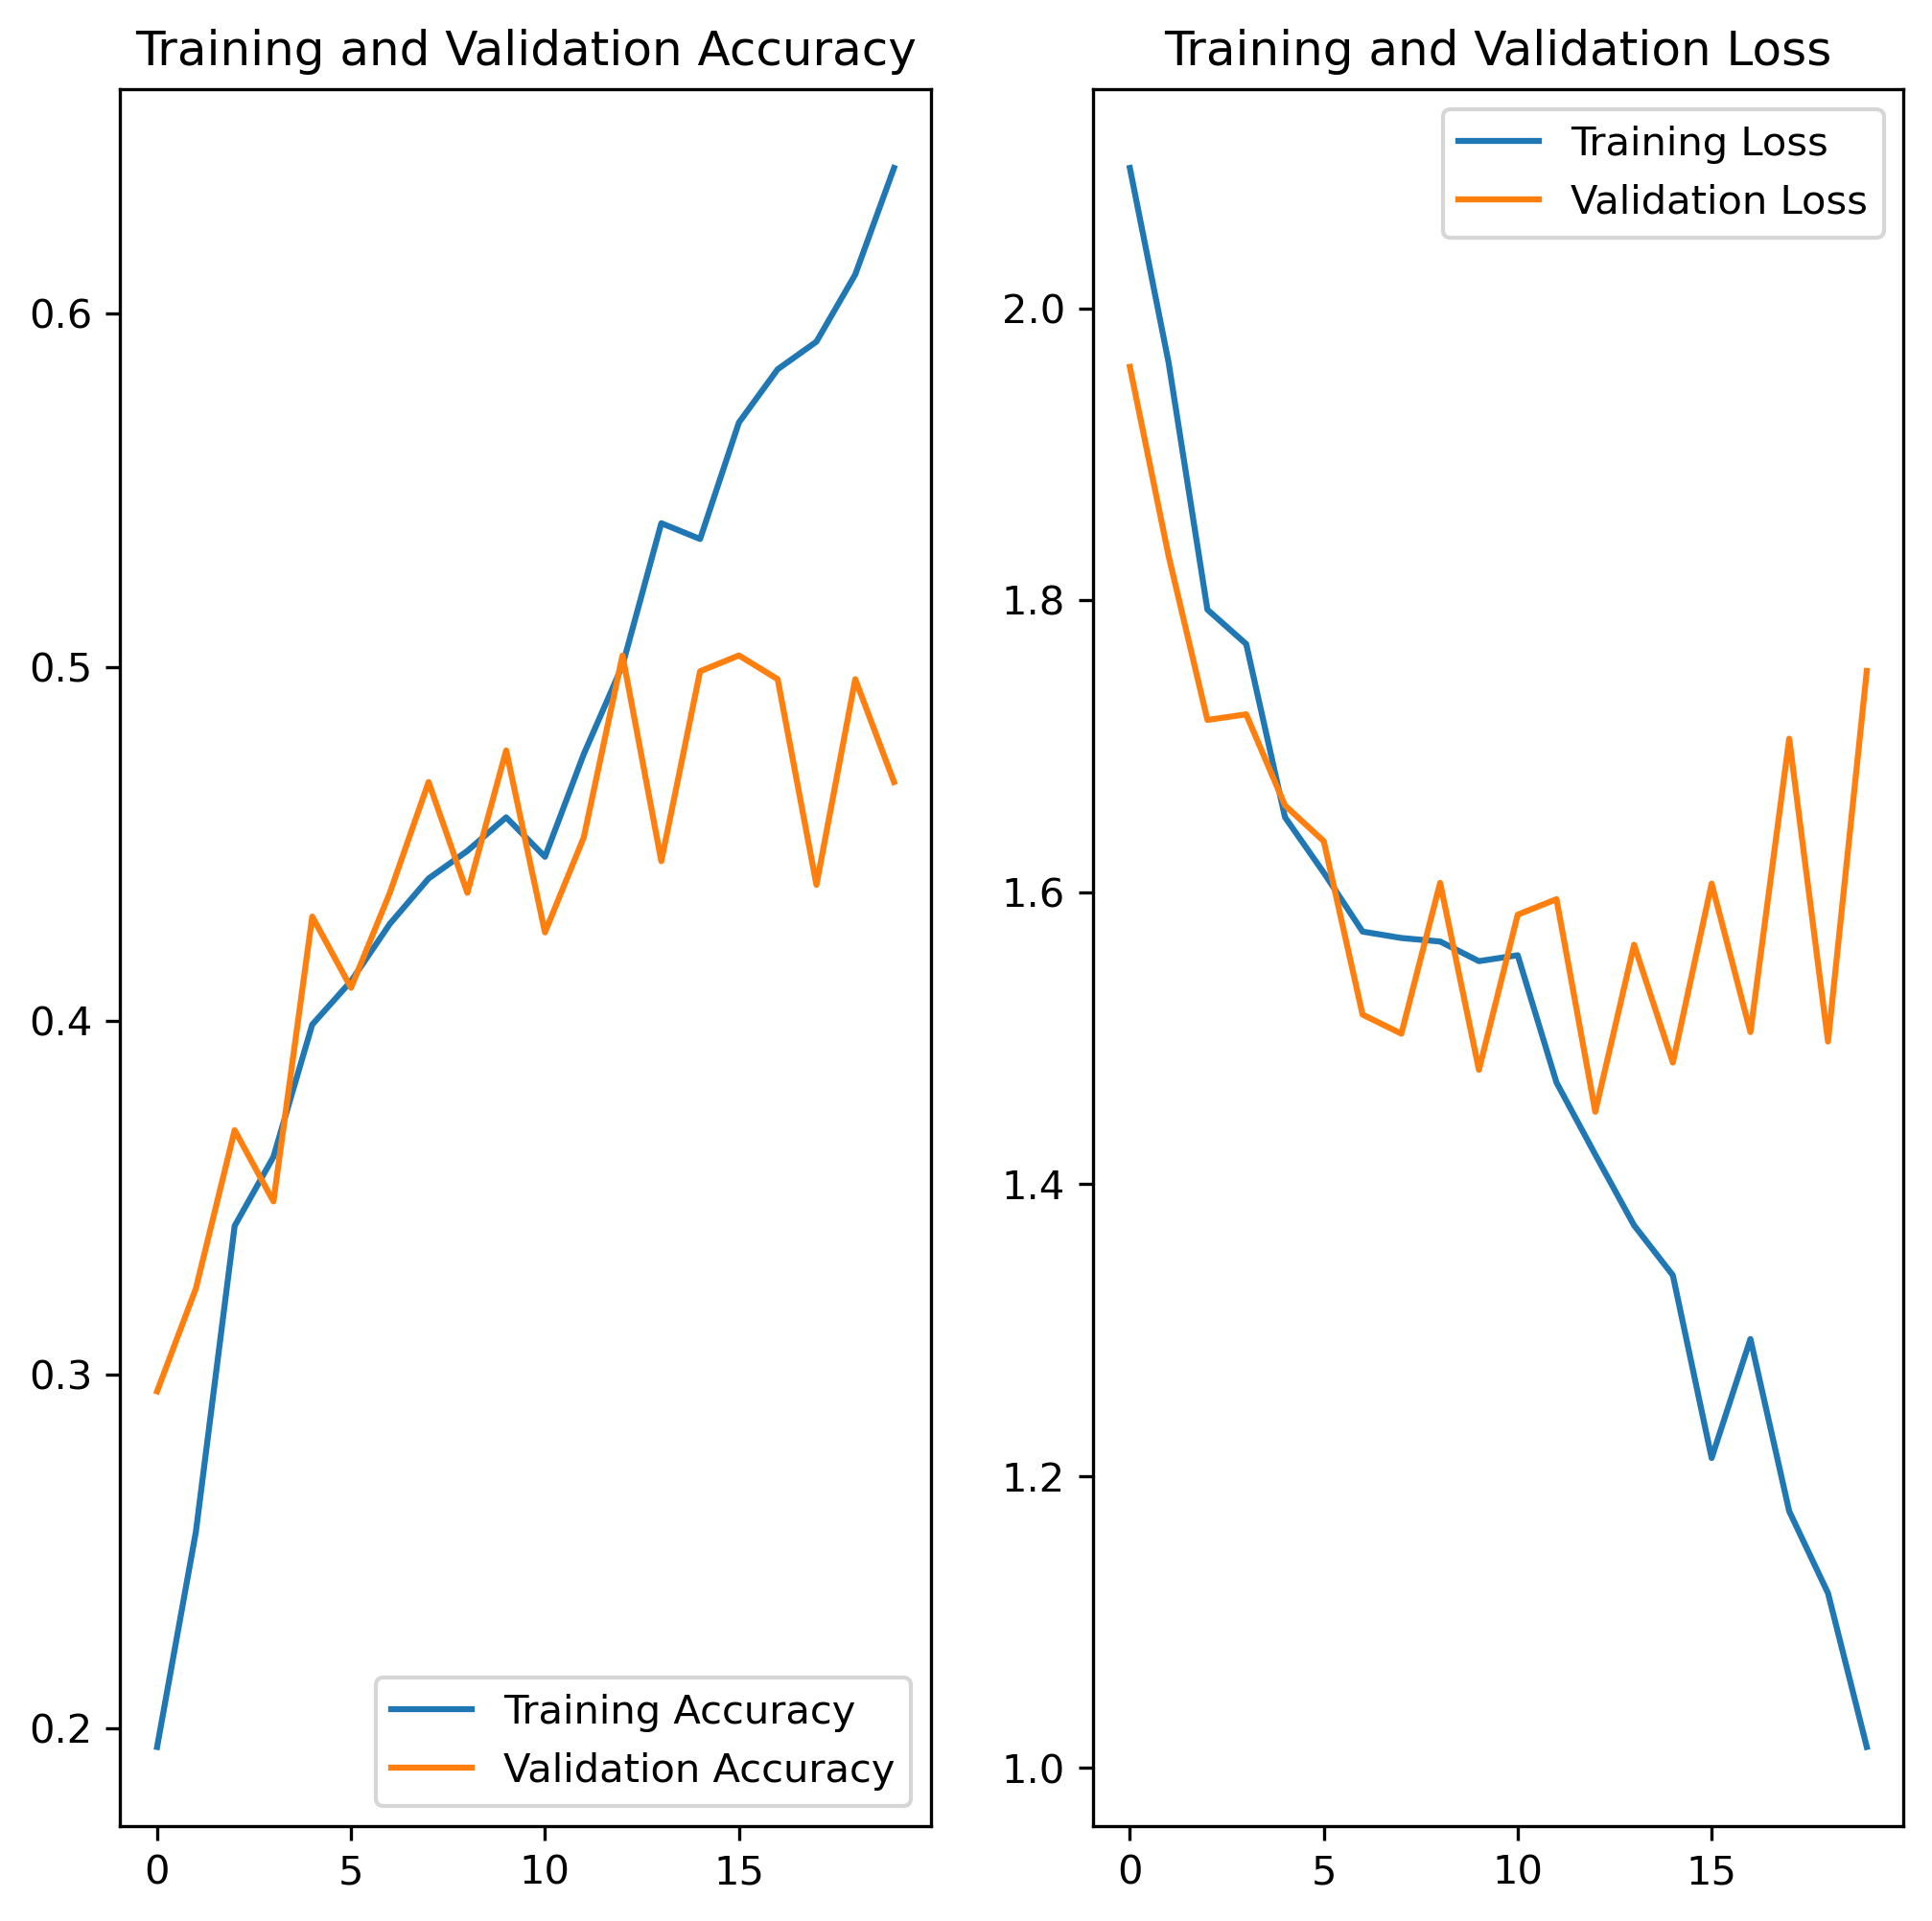

In [19]:
# visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8), dpi=300)

# plotting training and validation accuracies vs epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plotting training and validation losses vs epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# <font color='darkblue'>Performance of dcnn2:</font>
The <font color='darkblue'><b>accuracy</b></font> of the model on the <font color='darkblue'><b>training set</b></font> is at <font color='darkblue'><b>64%</b></font> which is a clear <font color='darkblue'><b>indication</b></font> of <font color='darkblue'><b>underfitting</b></font>  and on the <font color='darkblue'><b>validation set</b></font> it is just <font color='darkblue'><b>47%</b></font>. We may have to apply more changes to our <font color='darkblue'><b>DCNN model</b></font> to make it learn better and generalize better. Most importantly we can use the technique of <font color='darkblue'><b>data augmentation</b></font> in order to fix overfitting.

# <font color='darkblue'>Data Augmentation</font>

In [20]:
# introducing randomflips and random_rotations as a part of data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)])

# <font color='darkblue'>Visualizing the Augmented Data</font>

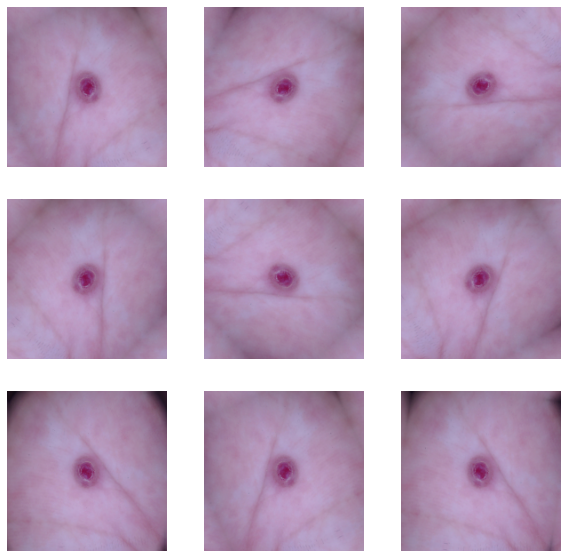

In [21]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    augmented_image1=np.array(augmented_image[0],np.int32)  
    plt.imshow((augmented_image1))
    plt.axis("off")

# <font color='darkblue'>Building 3rd model: dcnn3</font>

In [22]:
# building the deep CNN architecture with 3 convolutional units (2 convolutional layer + 1 maxpool)
# and 1 fully connected layer and dropout layers in between
# using softmax layer for the output 
dcnn3=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

In [23]:
# compiling the above DCNN model with adam optimizer and categorical_crossentropy loss
dcnn3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [24]:
# training the model for 20 epochs using the train_ds
epochs = 20
history = dcnn3.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs)

Epoch 1/20
56/56 [==============================] - 9s 142ms/step - loss: 2.0902 - accuracy: 0.1892 - val_loss: 2.0177 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 8s 141ms/step - loss: 2.0202 - accuracy: 0.2109 - val_loss: 2.0458 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 8s 142ms/step - loss: 1.9574 - accuracy: 0.2416 - val_loss: 1.8539 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 8s 142ms/step - loss: 1.8008 - accuracy: 0.3365 - val_loss: 1.9341 - val_accuracy: 0.2774
Epoch 5/20
56/56 [==============================] - 8s 141ms/step - loss: 1.7245 - accuracy: 0.3677 - val_loss: 1.6557 - val_accuracy: 0.3870
Epoch 6/20
56/56 [==============================] - 8s 140ms/step - loss: 1.6471 - accuracy: 0.4146 - val_loss: 1.6241 - val_accuracy: 0.3848
Epoch 7/20
56/56 [==============================] - 8s 143ms/step - loss: 1.6043 - accuracy: 0.4191 - val_loss: 1.5275 - val_accuracy: 0.4653
Epoch 

In [25]:
# glimpse of the architecture of dcnn3 model
dcnn3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 89, 89, 32)        0         
                                                      

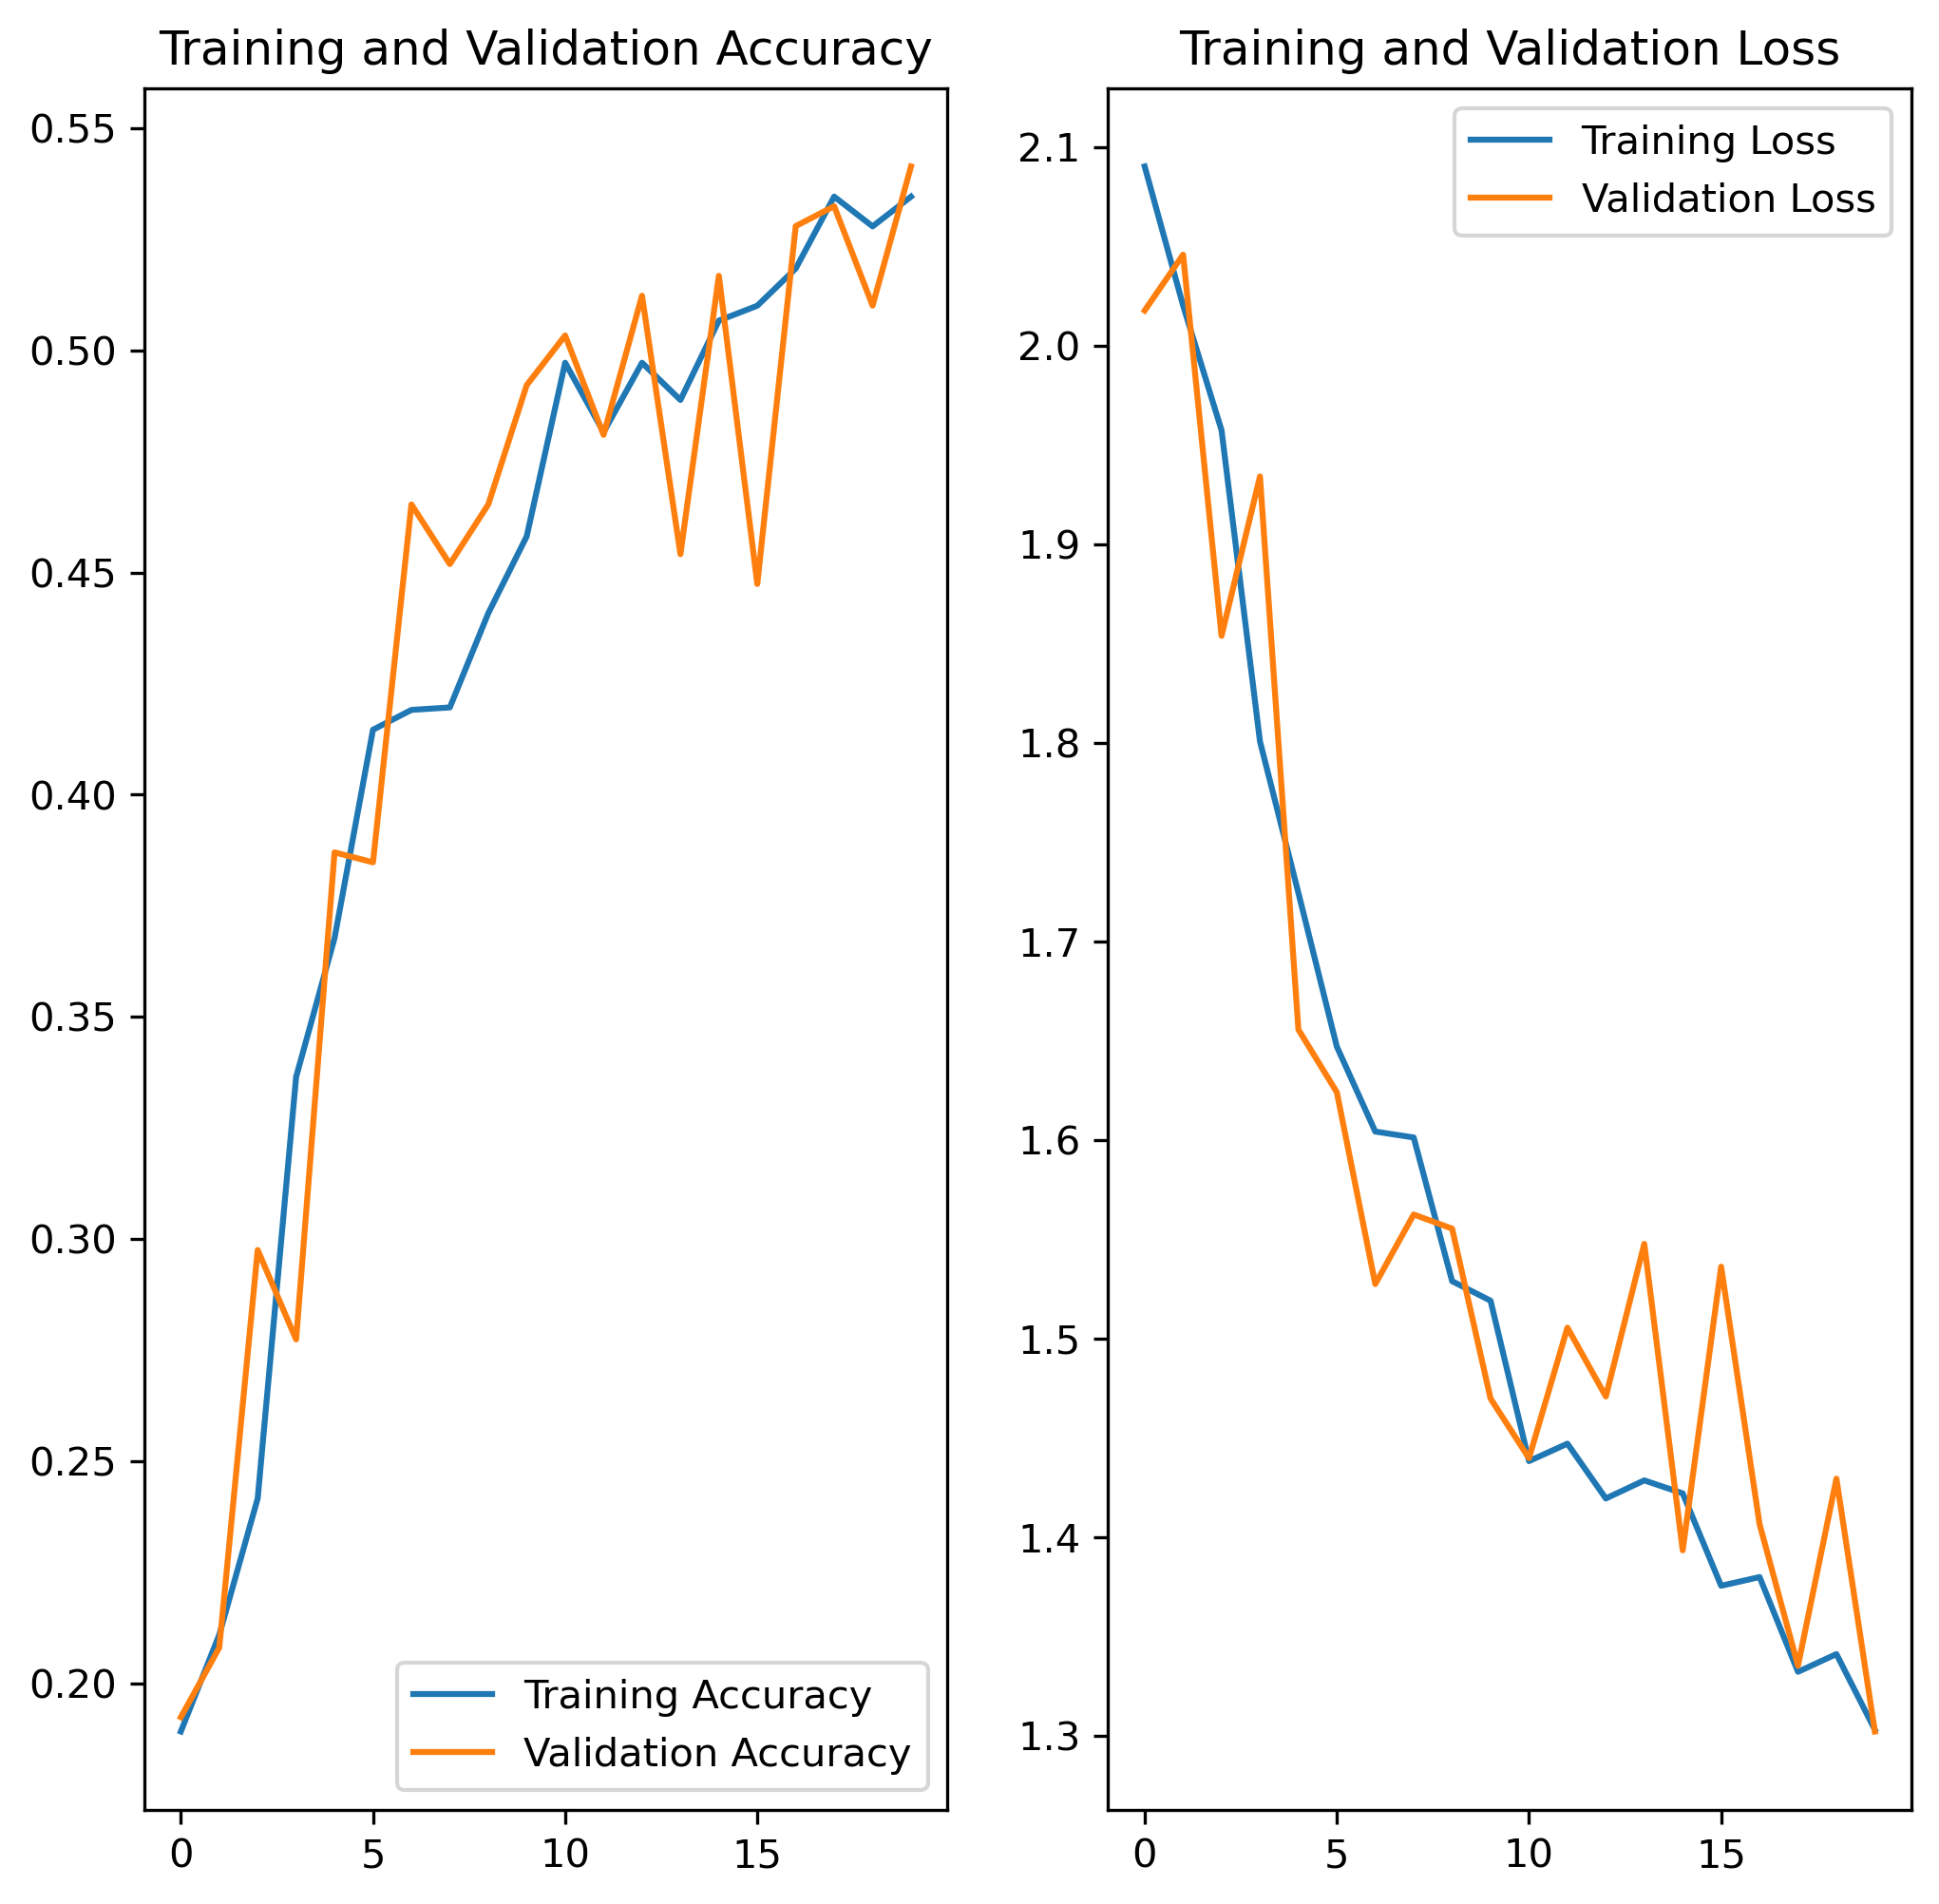

In [26]:
# visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8), dpi=300)

# plotting training and validation accuracies vs epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plotting training and validation losses vs epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# <font color='darkblue'>Performance of dcnn3:</font>
The <font color='darkblue'><b>accuracy</b></font> of the model on the <font color='darkblue'><b>training set</b></font> is at <font color='darkblue'><b>53%</b></font> and on the <font color='darkblue'><b>validation set</b></font> is <font color='darkblue'><b>54%</b></font>. Though <font color='darkblue'><b>data augmentation</b></font> helped resolve the issue of <font color='darkblue'><b>overfitting</b></font>, it is still not a good model because it is highly <font color='darkblue'><b>underfitting</b></font> and not learning useful patterns in the data. We may have to check our <font color='darkblue'><b>training set</b></font> itself for <font color='darkblue'><b>class balance</b></font> and if there's any <font color='darkblue'><b>imbalance</b></font> then we have to rectify it by <font color='darkblue'><b>adding more examples</b></font> to all <font color='darkblue'><b>classes</b></font>.

# <font color='darkblue'>Checking for Class Imbalance</font>

In [27]:
# checking the number of samples in each class
for i in class_names:
    directory =train_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


-  The samples of various classes are not in equal proportion.
-  There is a significant <font color='darkblue'><b>Class Imbalance</b></font> observed.
-  The class with the <font color='darkblue'><b>least number of samples</b></font> is <font color='darkblue'><b>Seborrheic Keratosis</b></font> with <font color='darkblue'><b>77</b></font>.
-  The class that <font color='darkblue'><b>dominates</b></font> the data in terms of <font color='darkblue'><b>proportionate number of samples</b></font> is <font color='darkblue'><b>Pigmented Benign Keratosis</b></font> with sample size of <font color='darkblue'><b>462</b></font>. 

# <font color='darkblue'>Using Augmentor for Class Imbalance Treatment</font>

To use <font color='darkblue'><b>Augmentor</b></font>, the following general procedure is followed:

1. Instantiate a <font color='darkblue'><b>Pipeline</b></font> object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your <font color='darkblue'><b>Pipeline</b></font> object.<br>
3. Execute these operations by calling the <font color='darkblue'>**Pipeline**</font>’s <font color='darkblue'><b>sample()</b></font> method.


In [28]:
# augmenting more images in each class
# note that this procedure is not going to make our data set perfectly balanced
# it'll just make sure that no particular class is sparse
path_to_training_dataset = train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) # higher the no. of samples, more balanced our dataset will be

Processing <PIL.Image.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.JpegIm
Processing <PIL.Image.

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.
Processing <PIL.Image.

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.
Processing <PIL.Image.

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.
Processing <PIL.Image.

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.
Processing <PIL.Image.

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.
Processing <PIL.Image.

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.
Processing <PIL.Image.

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.
Processing <PIL.JpegIm

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.


<font color='darkblue'><b>Augmentor</b></font> object has stored the <font color='darkblue'><b>augmented images</b></font> in the <font color='darkblue'><b>output sub-directory</b></font> of <font color='darkblue'><b>each</b></font> of the <font color='darkblue'><b>sub-directories</b></font> of <font color='darkblue'><b>skin cancer types</b></font>. Lets take a look at <font color='darkblue'><b>total count</b></font> of <font color='darkblue'><b>augmented images</b></font>.

In [29]:
# 500 augmented images for each of the 9 classes
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
# counting the total number of images including the augmented images
for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


Clearly we removed <font color='darkblue'><b>sparsity</b></font> in our <font color='darkblue'><b>training data set</b></font>.

# <font color='darkblue'>Creating New Training & Testing Data Set</font>

In [34]:
# creating new training set after augmentation
data_dir_train = train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [35]:
# creating new testing set after augmentation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# <font color='darkblue'>Building 4th model: dcnn4</font>

In [36]:
# building the deep CNN architecture with 2 convolutional units (convolutional layer + maxpool)
# and 1 fully connected layer and dropout layers in between
# using softmax layer for the output
dcnn4=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

In [37]:
# compiling the above DCNN model with adam optimizer and categorical_crossentropy loss
dcnn4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [38]:
# training the model for 30 epochs using the train_ds
epochs = 30
history = dcnn4.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs)

Epoch 1/30
169/169 [==============================] - 11s 60ms/step - loss: 2.2006 - accuracy: 0.2678 - val_loss: 1.6995 - val_accuracy: 0.4105
Epoch 2/30
169/169 [==============================] - 10s 56ms/step - loss: 1.5145 - accuracy: 0.4267 - val_loss: 1.4020 - val_accuracy: 0.4959
Epoch 3/30
169/169 [==============================] - 10s 57ms/step - loss: 1.3047 - accuracy: 0.5165 - val_loss: 1.1451 - val_accuracy: 0.5835
Epoch 4/30
169/169 [==============================] - 10s 57ms/step - loss: 1.1273 - accuracy: 0.5862 - val_loss: 1.0429 - val_accuracy: 0.6013
Epoch 5/30
169/169 [==============================] - 10s 57ms/step - loss: 0.9846 - accuracy: 0.6411 - val_loss: 0.9578 - val_accuracy: 0.6637
Epoch 6/30
169/169 [==============================] - 10s 58ms/step - loss: 0.8987 - accuracy: 0.6741 - val_loss: 0.9008 - val_accuracy: 0.6956
Epoch 7/30
169/169 [==============================] - 10s 58ms/step - loss: 0.7604 - accuracy: 0.7263 - val_loss: 0.9277 - val_accuracy:

In [39]:
# glimpse of the architecture of dcnn4 model
dcnn4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

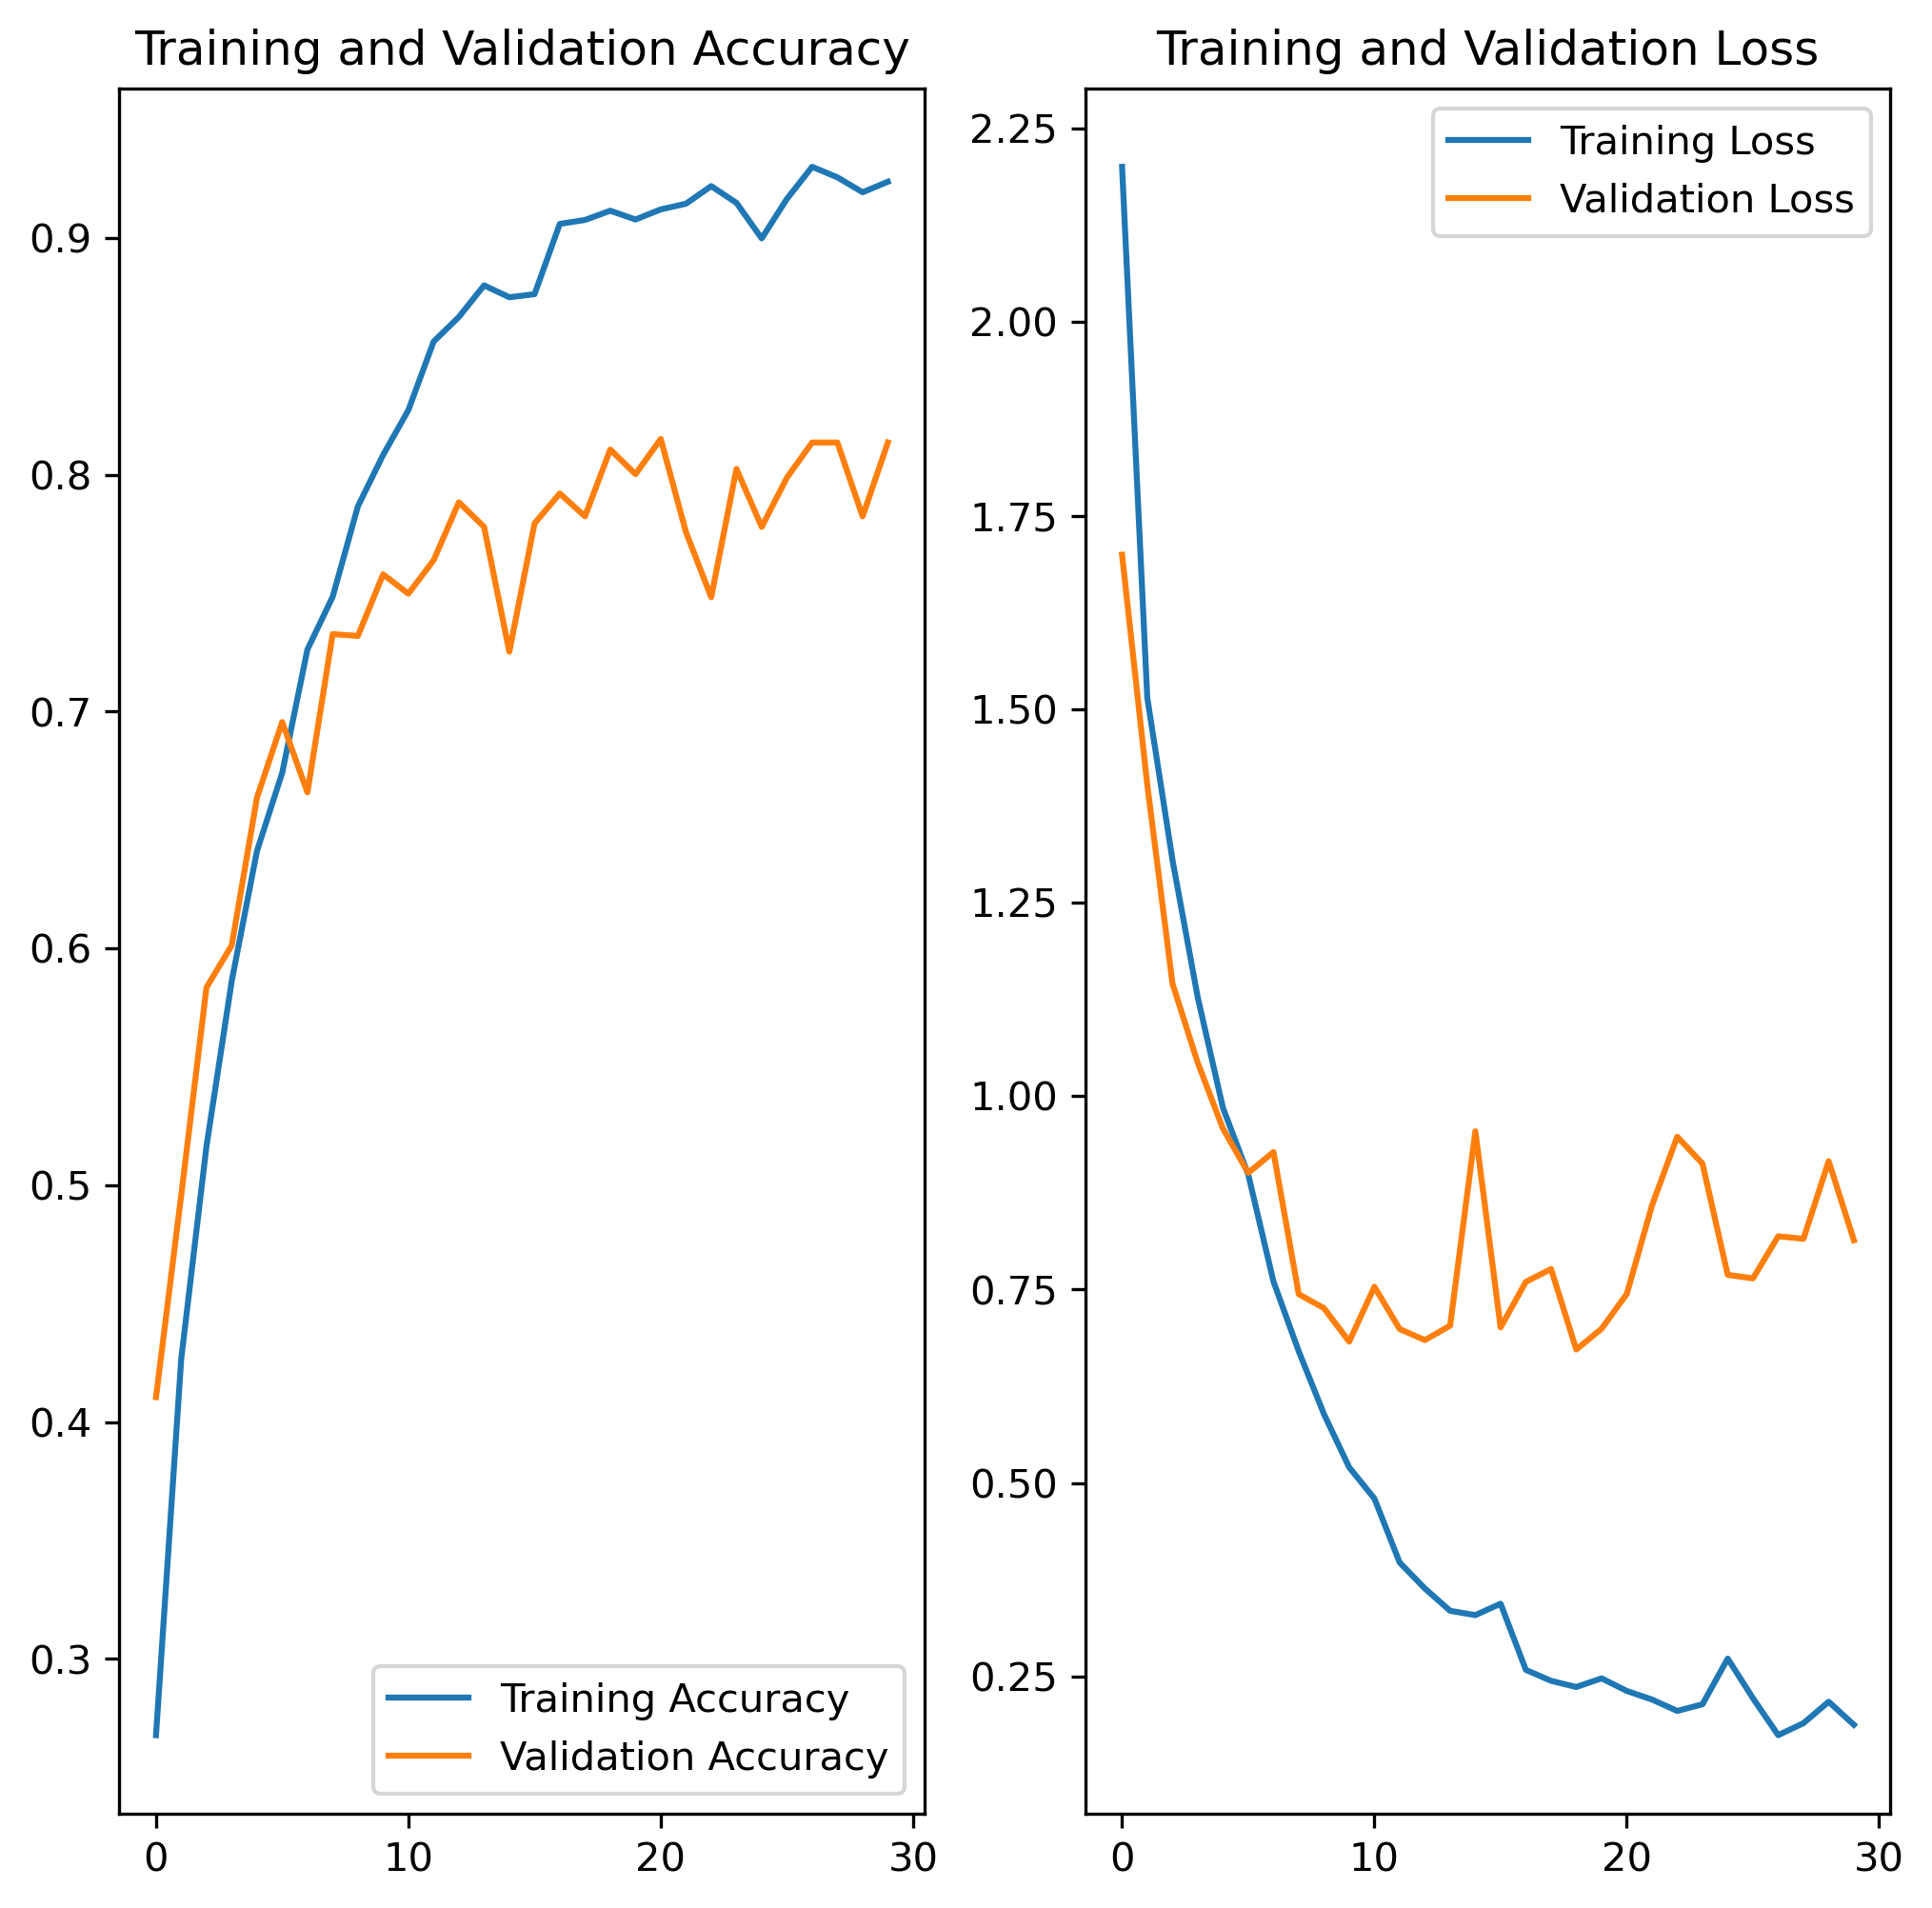

In [40]:
# visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8), dpi=300)

# plotting training and validation accuracies vs epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plotting training and validation losses vs epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# <font color='darkblue'>Performance of dcnn4:</font>
The <font color='darkblue'><b>accuracy</b></font> of the model on the <font color='darkblue'><b>training set</b></font> is at <font color='darkblue'><b>92%</b></font> and on the <font color='darkblue'><b>validation set</b></font> is <font color='darkblue'><b>81%</b></font>. Though the performance is decent, one can still argue that the model is <font color='darkblue'><b>overfitting</b></font>. Lets try adding few additional layers and dropout layers to our <font color='darkblue'><b>DCNN model</b></font> to build one <font color='darkblue'><b>final model</b></font> which can learn and generalize better.

# <font color='darkblue'>Building the final model: dcnn_final</font>

In [41]:
# building the deep CNN architecture with 3 convolutional units (convolutional layer + maxpool)
# and 2 fully connected layer and dropout layers in between
# using softmax layer for the output
dcnn_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(16,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dropout(0.5),   
    
    Dense(512, activation='relu'),
    Dropout(0.5),   
    
    Dense(256, activation='relu'),
    Dropout(0.5),   
    
    Dense(9, activation='softmax')
])

In [42]:
# compiling the above DCNN model with adam optimizer and categorical_crossentropy loss
dcnn_final.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics='accuracy')

In [43]:
# training the model for 30 epochs using the train_ds
epochs = 30
history = dcnn_final.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs)

Epoch 1/30
169/169 [==============================] - 10s 52ms/step - loss: 2.0161 - accuracy: 0.2190 - val_loss: 1.7208 - val_accuracy: 0.3660
Epoch 2/30
169/169 [==============================] - 9s 49ms/step - loss: 1.6740 - accuracy: 0.3539 - val_loss: 1.4952 - val_accuracy: 0.4083
Epoch 3/30
169/169 [==============================] - 9s 49ms/step - loss: 1.5437 - accuracy: 0.4141 - val_loss: 1.4125 - val_accuracy: 0.4662
Epoch 4/30
169/169 [==============================] - 9s 49ms/step - loss: 1.4094 - accuracy: 0.4653 - val_loss: 1.2815 - val_accuracy: 0.4959
Epoch 5/30
169/169 [==============================] - 9s 50ms/step - loss: 1.3005 - accuracy: 0.5089 - val_loss: 1.1551 - val_accuracy: 0.5568
Epoch 6/30
169/169 [==============================] - 9s 50ms/step - loss: 1.1942 - accuracy: 0.5543 - val_loss: 1.0775 - val_accuracy: 0.6162
Epoch 7/30
169/169 [==============================] - 9s 50ms/step - loss: 1.1130 - accuracy: 0.5842 - val_loss: 0.9334 - val_accuracy: 0.653

In [44]:
# glimpse of the architecture of dcnn3 model
dcnn_final.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 45, 45, 64)       

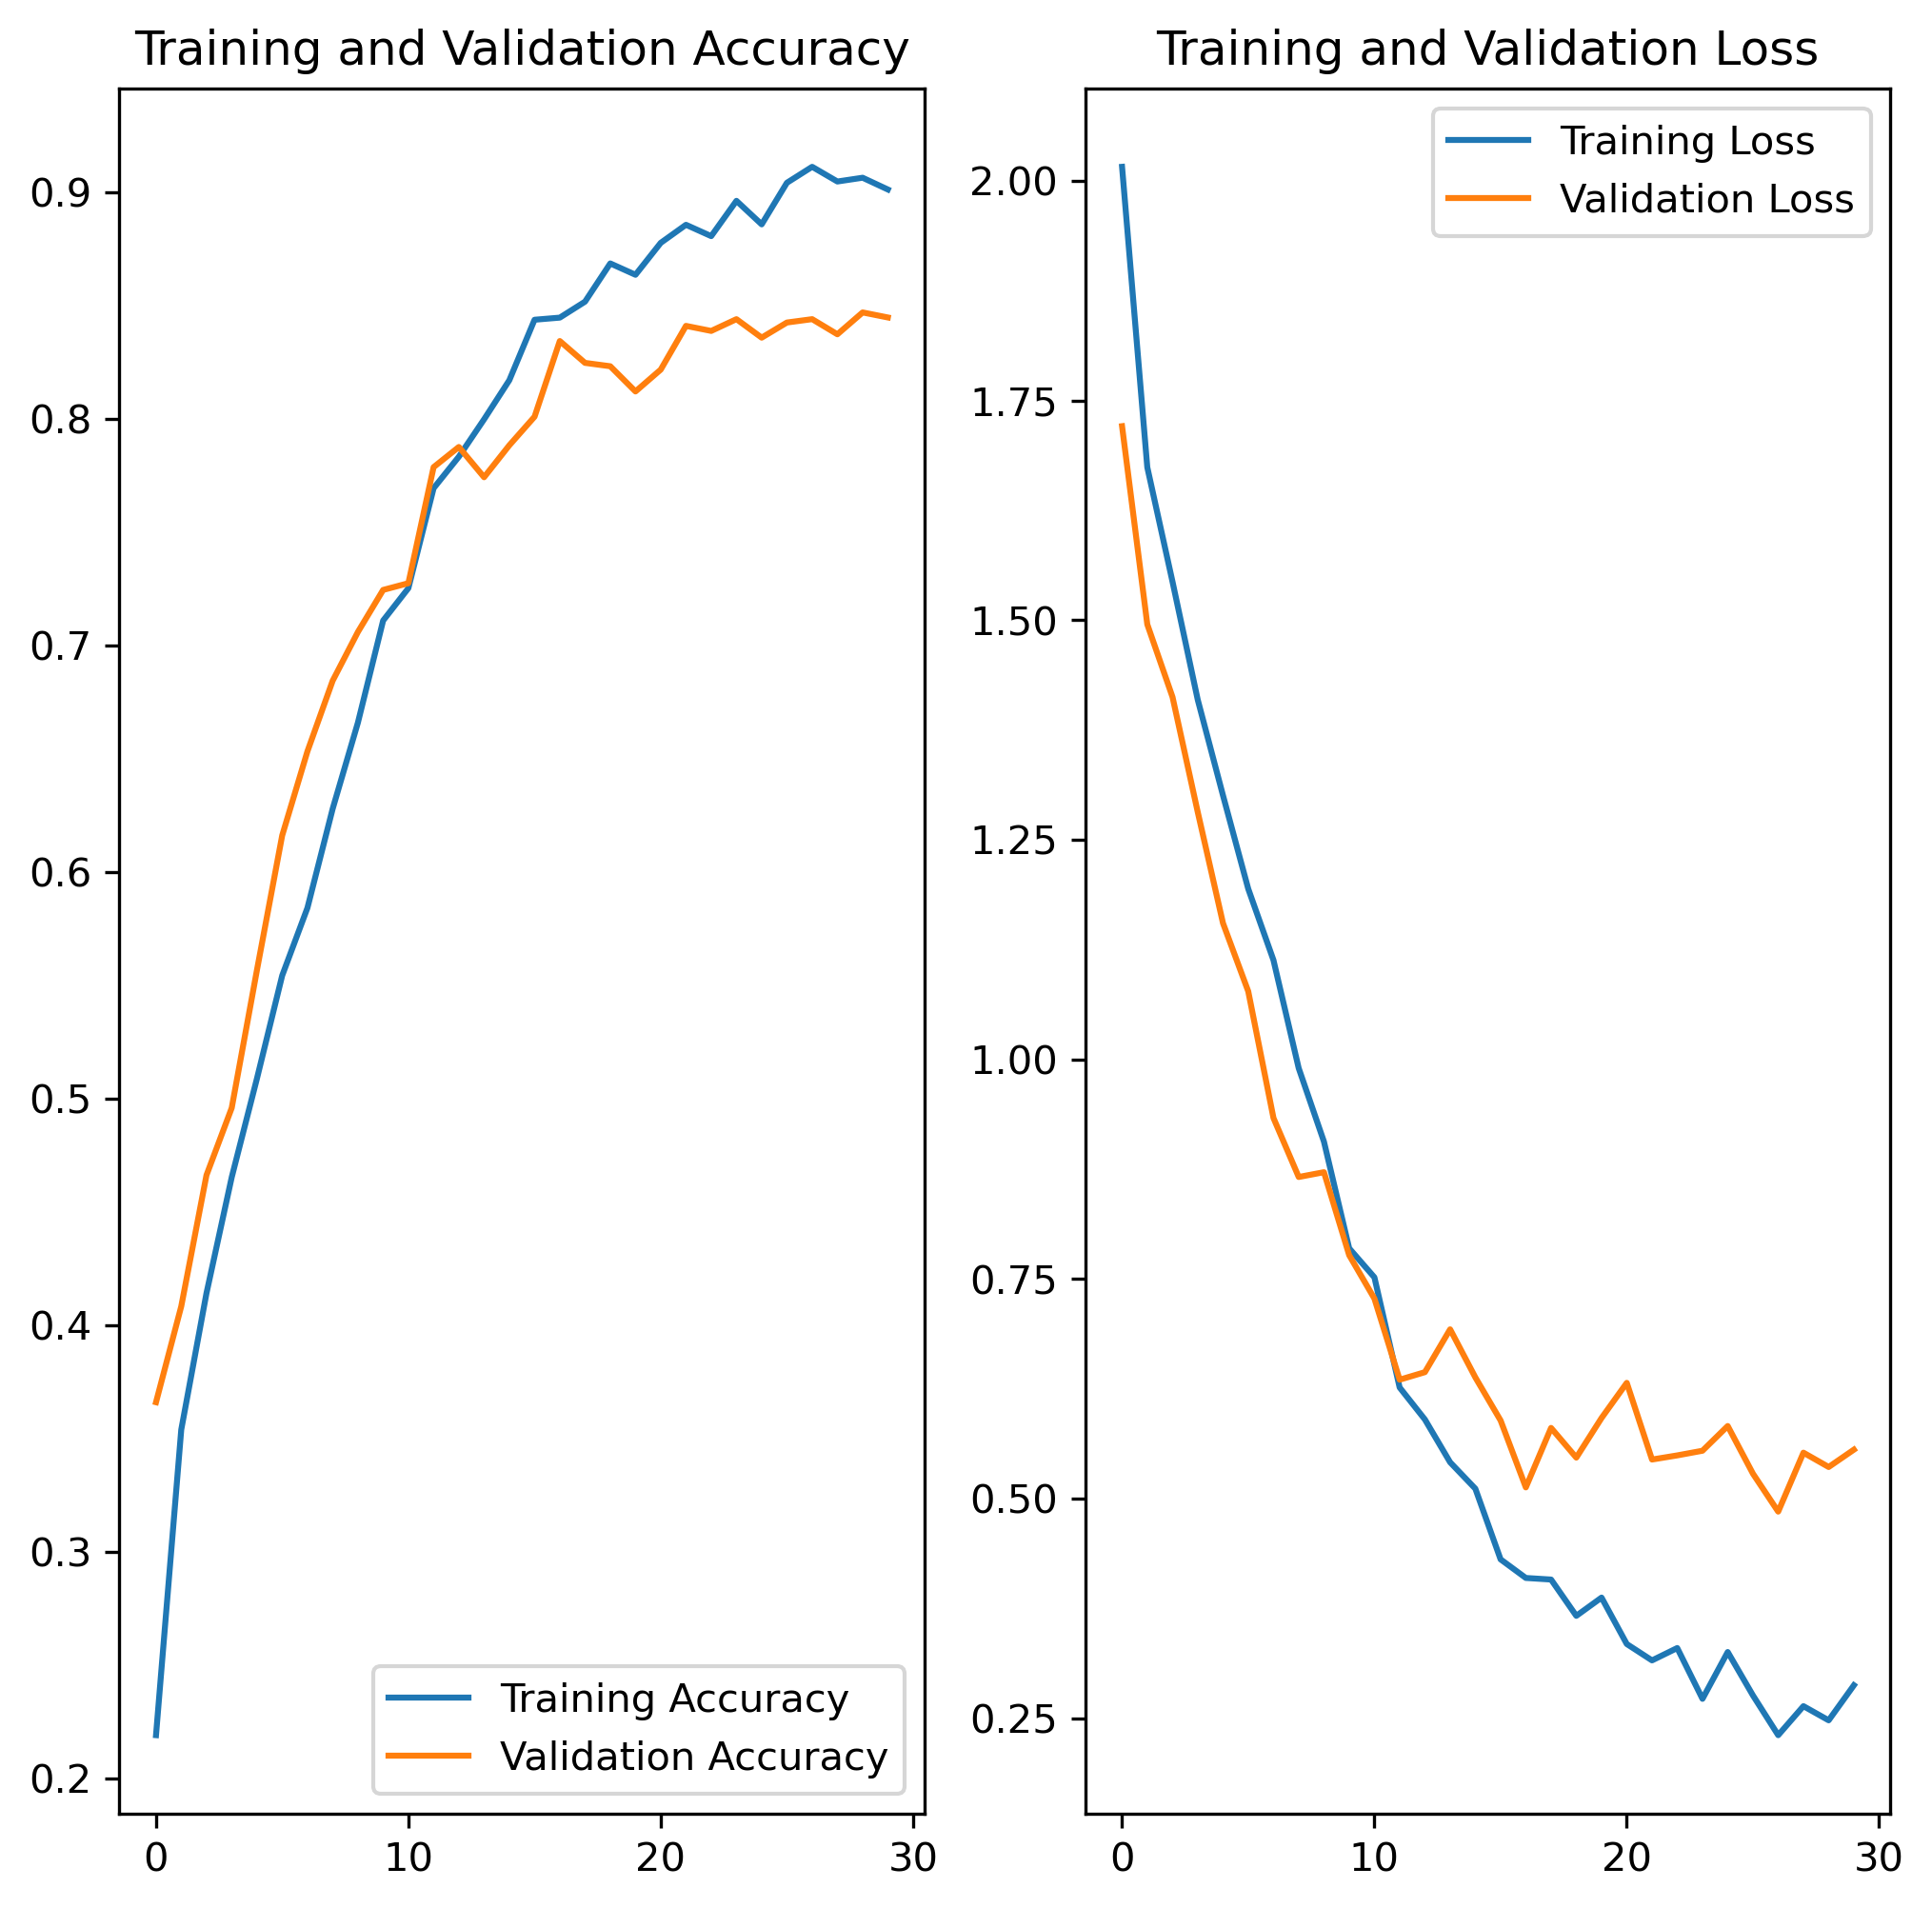

In [45]:
# visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8), dpi=300)

# plotting training and validation accuracies vs epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plotting training and validation losses vs epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# <font color='darkblue'>Performance of dcnn_final:</font>
The <font color='darkblue'><b>accuracy</b></font> of the model on the <font color='darkblue'><b>training set</b></font> is at <font color='darkblue'><b>90%</b></font> and on the <font color='darkblue'><b>validation set</b></font> is <font color='darkblue'><b>85%</b></font>. Thus <font color='darkblue'><b>dcnn_final</b></font> is a <font color='darkblue'><b>well-generalizing DCNN model</b></font>. 